In [27]:
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

import regionmask



In [2]:
mloc = "/Volumes/Drudonna/MODIS/processed"
mds = xr.open_dataset( mloc+"/"+"cltmodis_MCD06COSPM3_MODIS_v062_200207-202207.nc")

In [4]:
iloc = "/Volumes/Drudonna/ISCCPH"
ids = xr.open_dataset(iloc + "/" + "cltisccp_mon_HGM.v01r00_198307-201612.nc")

In [21]:
print(mds['cltmodis'].shape)
print(ids['cltisccp'].shape)

(241, 180, 360)
(402, 180, 360)


In [7]:
imean = ids['cltisccp'].weighted(np.cos(np.radians(ids['lat']))).mean(dim=("lat","lon"))

In [8]:
mmean = mds['cltmodis'].weighted(np.cos(np.radians(ids['lat']))).mean(dim=("lat","lon"))

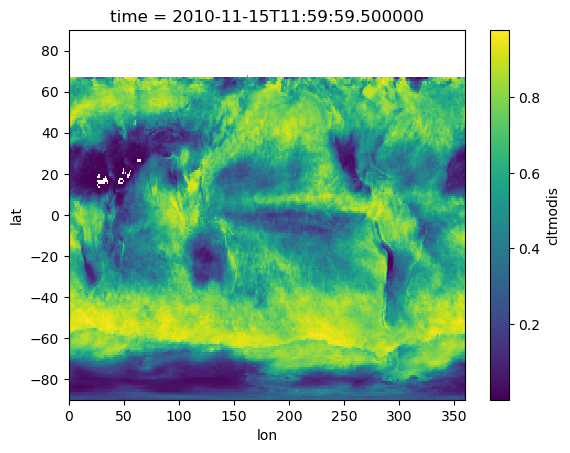

In [20]:
msample = mds['cltmodis'].sel(time="2010-11-15", method='nearest')
msample = xr.where(msample <= 0, np.nan, msample)
msample.plot.pcolormesh()

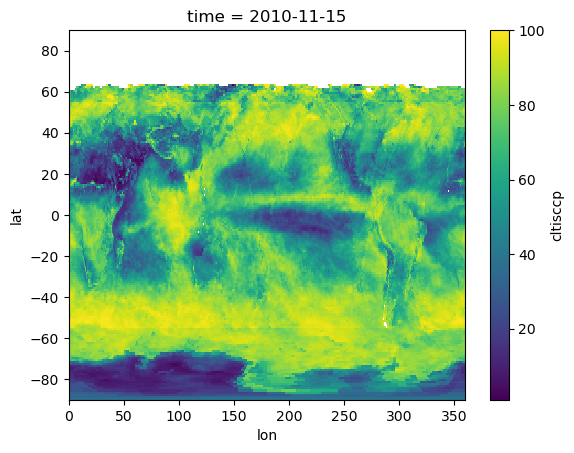

In [22]:
isample = ids['cltisccp'].sel(time="2010-11-15", method='nearest')
isample = xr.where(isample <= 0, np.nan, isample)
isample.plot.pcolormesh()

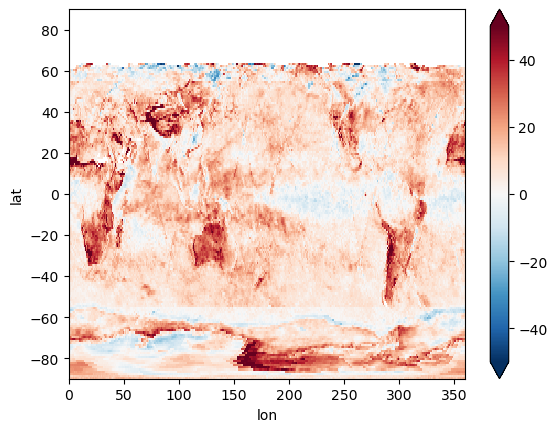

In [25]:
(isample-100*msample).plot.pcolormesh(vmin=-50, vmax=50, cmap='RdBu_r')

In [54]:
def create_ocean_mask(ds):
    ocean = xr.where(regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(mds), 1, 0 )

    # Apply mask to the dataset
    if isinstance(ds, xr.Dataset):
        return ds * xr.where(ocean == 1, 1, np.nan)
    else:
        return xr.where(ocean == 1, ds, np.nan)


In [57]:
mask_modis = create_ocean_mask(msample)
mask_isccp = create_ocean_mask(isample)


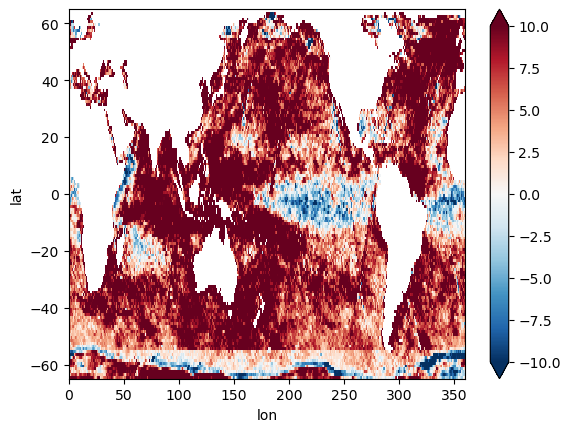

In [64]:
(mask_isccp - 100*mask_modis).sel(lat=slice(-65,65)).plot(vmin=-10, vmax=10, cmap='RdBu_r')

In [72]:
mask_modis = create_ocean_mask(mds['cltmodis'])
mask_isccp = create_ocean_mask(ids['cltisccp'])

mask_modis = xr.where(mask_modis <= 0, np.nan, mask_modis)
mask_isccp = xr.where(mask_isccp <= 0, np.nan, mask_isccp)


mask_modis = mask_modis.sel(lat=slice(-65,65))
mask_isccp = mask_isccp.sel(lat=slice(-65,65))

imean = mask_isccp.weighted(np.cos(np.radians(mask_isccp.lat))).mean(dim=("lat","lon"))
mmean = mask_modis.weighted(np.cos(np.radians(mask_modis.lat))).mean(dim=("lat","lon"))

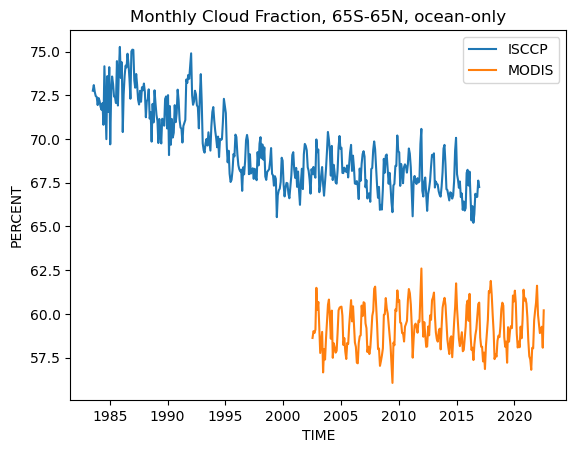

In [107]:
fig, ax = plt.subplots()
ax.plot(imean.time, imean, label="ISCCP")
ax.plot(mmean.time, mmean*100, label="MODIS")
ax.set_title("Monthly Cloud Fraction, 65S-65N, ocean-only")
ax.set_ylabel("PERCENT")
ax.set_xlabel("TIME")
ax.legend()

/var/folders/vr/glysjw691_d8n5wxl0vnzx7w0000gp/T/ipykernel_33745/3955293179.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


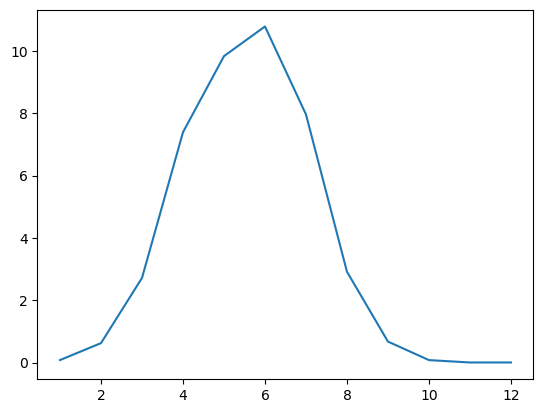

In [78]:
import numpy as np
import pandas as pd

def generate_seasonal_data(start_year=2000, end_year=2023, base_amplitude=10, noise_factor=0.2, peak_months=[5, 6]):
    """
    Generate synthetic monthly time series data with seasonal pattern.
    
    Parameters:
    -----------
    start_year : int
        Starting year for the time series
    end_year : int
        Ending year for the time series
    base_amplitude : float
        Base amplitude for the seasonal signal
    noise_factor : float
        Factor controlling the amount of noise (relative to local mean)
    peak_months : list
        List of months (1-12) where the signal peaks
    
    Returns:
    --------
    pd.Series
        Time series with seasonal pattern and heteroscedastic noise
    """
    # Create date range
    dates = pd.date_range(
        start=f'{start_year}-01-01',
        end=f'{end_year}-12-31',
        freq='M'
    )
    
    # Create base seasonal pattern
    months = np.array([d.month for d in dates])
    base_values = np.zeros(len(dates))
    
    # Generate smooth seasonal pattern
    for month in range(1, 13):
        # Calculate distance to peak months (circular)
        distances = min(
            abs(month - peak) if abs(month - peak) <= 6 
            else 12 - abs(month - peak)
            for peak in peak_months
        )
        # Use gaussian-like decay from peaks
        base_values[months == month] = base_amplitude * np.exp(-0.3 * distances**2)
    
    # Add noise proportional to local mean
    noise = np.random.normal(
        loc=0,
        scale=noise_factor * base_values,
        size=len(dates)
    )
    
    # Combine signal and noise, ensure no negative values
    values = base_values + noise
    values = np.maximum(values, 0)
    
    # Create pandas Series
    ts = pd.Series(values, index=dates)
    
    return ts


## RUN IT
np.random.seed(42)  # for reproducibility

# Generate data
data = generate_seasonal_data(
    start_year=2000,
    end_year=2023,
    base_amplitude=10,
    noise_factor=0.2
)

# Print monthly statistics
monthly_stats = data.groupby(data.index.month).agg(['mean', 'std'])
# print("\nMonthly Statistics:")
# print(monthly_stats)

# Optional plotting code
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values)
plt.title('Synthetic Seasonal Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()
"""
plt.plot( monthly_stats['mean'])


In [82]:
dd = xr.DataArray(data, dims=['time'], coords={'time':data.index})

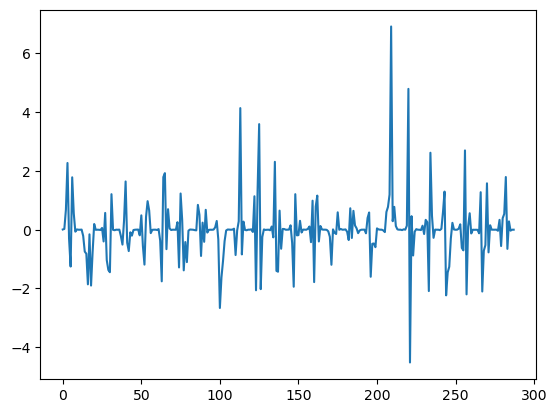

In [87]:
deseason = dd.groupby('time.month') - dd.groupby('time.month').mean(dim='time')
plt.plot(deseason)

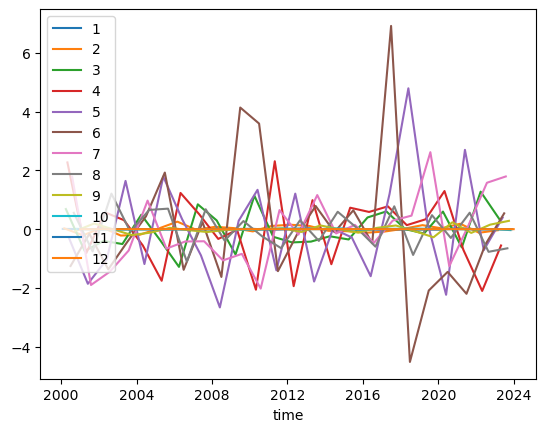

In [100]:
for i in range(1,13):
    deseason[deseason.time.dt.month == i].plot(label=i)
plt.legend()

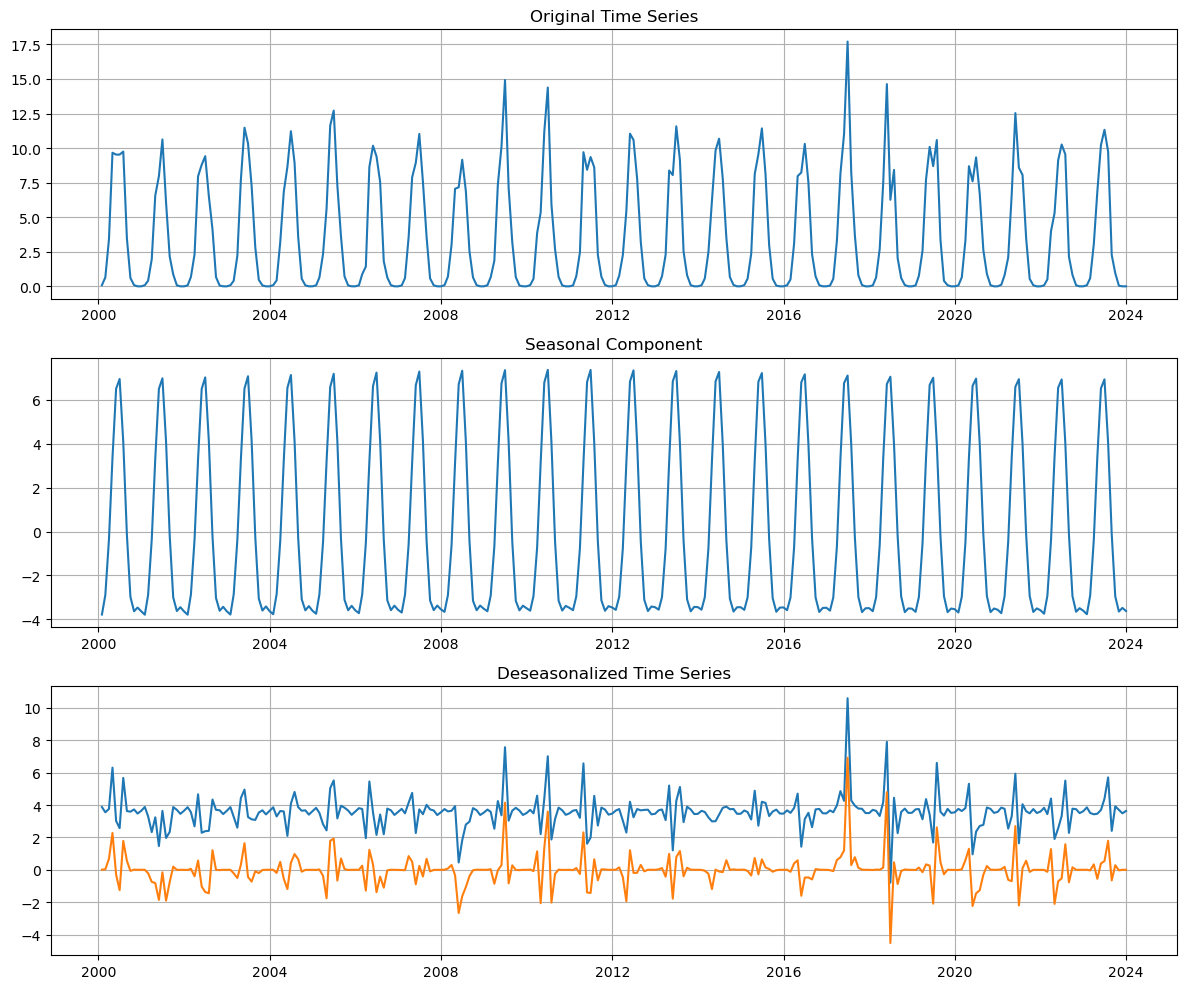

In [105]:
from scipy.fft import fft, ifft, fftfreq

def deseasonalize_fft(data, seasonal_period=12, filter_harmonics=3):
    """
    Remove seasonal cycle from time series using FFT filtering.
    
    Parameters:
    -----------
    data : pd.Series
        Input time series with datetime index
    seasonal_period : int
        Number of time steps in seasonal cycle (12 for monthly data)
    filter_harmonics : int
        Number of seasonal harmonics to filter out
    
    Returns:
    --------
    pd.Series
        Deseasonalized time series
    pd.Series
        Seasonal component that was removed
    """
    # Get values and ensure no NaNs
    values = data.values
    if np.any(np.isnan(values)):
        raise ValueError("Input data contains NaN values")
    
    # Compute FFT
    n = len(values)
    fft_values = fft(values)
    freqs = fftfreq(n)
    
    # Create mask for seasonal frequencies
    mask = np.ones(n, dtype=bool)
    fundamental_freq = 1.0 / seasonal_period
    
    for harmonic in range(1, filter_harmonics + 1):
        seasonal_freq = fundamental_freq * harmonic
        # Find frequencies close to seasonal frequency and its harmonics
        seasonal_idx = np.where(np.abs(np.abs(freqs) - seasonal_freq) < (1.0 / n))[0]
        mask[seasonal_idx] = False
    
    # Create seasonal and deseasonalized components
    fft_seasonal = fft_values.copy()
    fft_seasonal[mask] = 0  # Keep only seasonal frequencies
    seasonal = pd.Series(
        ifft(fft_seasonal).real,
        index=data.index
    )
    
    fft_deseasonalized = fft_values.copy()
    fft_deseasonalized[~mask] = 0  # Remove seasonal frequencies
    deseasonalized = pd.Series(
        ifft(fft_deseasonalized).real,
        index=data.index
    )
    
    return deseasonalized, seasonal



spec_deseas, spec_seas = deseasonalize_fft(data)
# Optional plotting code to visualize results

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Original data
ax1.plot(data.index, data.values)
ax1.set_title('Original Time Series')
ax1.grid(True)

# Seasonal component
ax2.plot(spec_seas.index, spec_seas.values)
ax2.set_title('Seasonal Component')
ax2.grid(True)

# Deseasonalized data
ax3.plot(spec_deseas.index, spec_deseas.values)
ax3.plot(deseason['time'], deseason)
ax3.set_title('Deseasonalized Time Series')
ax3.grid(True)

plt.tight_layout()
